In [44]:
import duckdb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
con = duckdb.connect(':memory:')

In [5]:
c4_urls = con.execute("SELECT url FROM '../c4/data/*.parquet' WHERE url LIKE '%nytimes.com%';").fetchdf()

In [7]:
cc_urls = con.execute("SELECT * FROM '../data/nyt_cc.csv';").fetchdf()

In [17]:
def parse_url(url):
    parts = url.split('/')
    try:
        year = int(parts[3])
        section = parts[6]
        return year, section
    except Exception:
        return None, None


In [19]:
cc_urls["metadata"] = cc_urls.url.apply(parse_url)

In [21]:
cc_urls["year"] = cc_urls.metadata.apply(lambda x: x[0])
cc_urls["section"] = cc_urls.metadata.apply(lambda x: x[1])

In [24]:
c4_urls["metadata"] = c4_urls.url.apply(parse_url)
c4_urls["year"] = c4_urls.metadata.apply(lambda x: x[0])
c4_urls["section"] = c4_urls.metadata.apply(lambda x: x[1])

/var/folders/m8/v1brzj4s56g48wwmpht61td40000gq/T/ipykernel_14339/1928098392.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered["delta"] = filtered.C4 - filtered.CC


Text(0.5, 1.0, 'Difference in Section Distribution between C4 and Common Crawl')

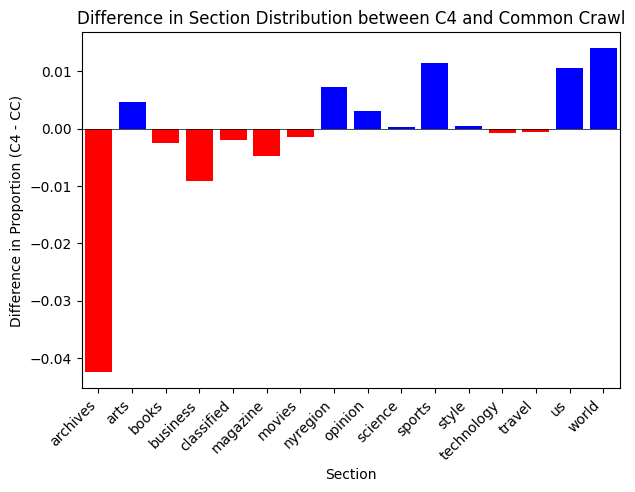

In [50]:
# Calculate proportions for each section in both dataframes
cc_section_props = (cc_urls[cc_urls.section.notna()]
                   .groupby('section')
                   .size()
                   .div(len(cc_urls[cc_urls.section.notna()]))
                   .sort_values(ascending=False))

c4_section_props = (c4_urls[c4_urls.section.notna()]
                   .groupby('section')
                   .size()
                   .div(len(c4_urls[c4_urls.section.notna()]))
                   .sort_values(ascending=False))

# Combine the proportions into a single dataframe for comparison
comparison = pd.DataFrame({
    'CC': cc_section_props,
    'C4': c4_section_props
}).fillna(0)

filtered = comparison[(comparison.CC > 0.01) | (comparison.C4 > 0.01)]
filtered["delta"] = filtered.C4 - filtered.CC

sns.barplot(x=filtered.index, y="delta", data=filtered)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
for i, v in enumerate(filtered["delta"]):
    color = 'red' if v < 0 else 'blue'
    plt.gca().patches[i].set_facecolor(color)
plt.xlabel('Section')
plt.ylabel('Difference in Proportion (C4 - CC)')
plt.title('Difference in Section Distribution between C4 and Common Crawl')

In [46]:
filtered

,CC,C4,delta
section,,,
archives,0.200687,0.158224,0.042463
arts,0.044235,0.048896,-0.004661
books,0.023819,0.021285,0.002535
business,0.111712,0.102585,0.009127
classified,0.029172,0.027127,0.002045
magazine,0.016509,0.011729,0.004781
movies,0.018408,0.016889,0.001520
nyregion,0.079289,0.086591,-0.007302
opinion,0.059747,0.062755,-0.003007


In [27]:
cc_urls[cc_urls.section.notna()].groupby("section").count().sort_values("url", ascending=False)

,url,metadata,year
section,,,
archives,86976,86976,86976
business,48415,48415,48415
nyregion,34363,34363,34363
us,32204,32204,32204
world,28717,28717,28717
...,...,...,...
comedy-at-national-theater-sparks-protest,1,1,1
notes-on-japan,1,1,1
combating-worry,1,1,1


In [25]:
cc_urls

,url,metadata,year,section
0,http://www.mnytimes.com/robots.txt,"(None, None)",NaN,None
1,http://mnytimes.com/robots.txt,"(None, None)",NaN,None
2,http://www.mobilenytimes.com/robots.txt,"(None, None)",NaN,None
3,http://0-nytimes.com.library.wvm.edu/robots.txt,"(None, None)",NaN,None
4,http://ww17.cnytimes.com/robots.txt,"(None, None)",NaN,None
...,...,...,...,...
636357,http://rss.nytimes.com/services/xml/rss/nyt/Sp...,"(None, None)",NaN,None
636358,http://rss.nytimes.com/services/xml/rss/nyt/Sp...,"(None, None)",NaN,None
636359,http://rss.nytimes.com/services/xml/rss/nyt/Te...,"(None, None)",NaN,None
636360,http://rss.nytimes.com/services/xml/rss/nyt/US...,"(None, None)",NaN,None
